In [31]:
# !pip install tensorflow

In [32]:
# !pip install git+https://github.com/tensorflow/examples.git

In [33]:
# !pip install matplotlib

In [34]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import pathlib as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [35]:
DATA_DIR = pl.Path(
    'person segmentation',
    'people_segmentation'
)
IMAGES_DIR = DATA_DIR / 'images'
MASKS_DIR = DATA_DIR / 'masks'

In [36]:
def load_data(path: pl.Path, split: float = 0.1):
    X = sorted(map(str, IMAGES_DIR.iterdir()))
    Y = sorted(map(str, MASKS_DIR.iterdir()))

    split_size = int(len(X) * split)

    train_x, val_x = train_test_split(X, test_size=split_size, random_state=42, shuffle=False)
    train_y, val_y = train_test_split(Y, test_size=split_size, random_state=42, shuffle=False)

    return (train_x, train_y), (val_x, val_y)

(train_x, train_y), (val_x, val_y) = load_data(DATA_DIR)

print("training data size:", len(train_x), "\nvalidation data size:", len(val_x))

training data size: 5111 
validation data size: 567


In [37]:
MASK_CHANNELS = 1
IMG_SIZE = 512, 512, 3
IMG_CHANNELS = IMG_SIZE[2]

BATCH_SIZE = 8
OUTPUT_CLASSES = 2

In [38]:
def parse_data(image_paths, mask_paths):
    image_content = tf.io.read_file(image_paths)
    mask_content = tf.io.read_file(mask_paths)

    images = tf.image.decode_jpeg(image_content, channels=IMG_CHANNELS)
    masks = tf.image.decode_jpeg(mask_content, channels=MASK_CHANNELS)
    masks = tf.minimum(masks, 1)
    return images, masks

def one_hot_encode(image, mask):
    unique_category_count = OUTPUT_CLASSES
    encoded_mask = tf.one_hot(mask, unique_category_count, axis=-1)
    encoded_mask = tf.squeeze(encoded_mask, axis=2) 
    return image, encoded_mask

def resize_data(image, mask):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, IMG_SIZE[:2])
    mask = tf.image.resize(mask, IMG_SIZE[:2], method="nearest")
    return image, mask

def flip_left_right(image, mask):
    image = tf.image.stateless_random_flip_left_right(image, seed = (2, 3))
    mask = tf.image.stateless_random_flip_left_right(mask, seed = (2, 3))
    return image, mask

In [39]:
auto = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))\
    .shuffle(1000)\
    .map(parse_data)\
    .map(resize_data)\
    .map(flip_left_right)\
    .map(one_hot_encode)\
    .batch(BATCH_SIZE)\
    .prefetch(auto)

val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y))\
    .shuffle(1000)\
    .map(parse_data)\
    .map(resize_data)\
    .map(flip_left_right)\
    .map(one_hot_encode)\
    .batch(BATCH_SIZE)\
    .prefetch(auto)

print(f"""
Train dataset: {len(train_x)}
Validation dataset: {len(val_x)}
""")


Train dataset: 5111
Validation dataset: 567


In [40]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [41]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [42]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [43]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[IMG_SIZE[0], IMG_SIZE[1], 3])
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [44]:
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [45]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def decode_one_hot(mask):
    dec_mask = tf.math.argmax(mask, axis=-1)
    dec_mask = dec_mask[..., tf.newaxis]
    pred_mask = tf.squeeze(dec_mask, axis=-1)
    return pred_mask

def show_predictions(dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], create_mask(mask), create_mask(pred_mask)])

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


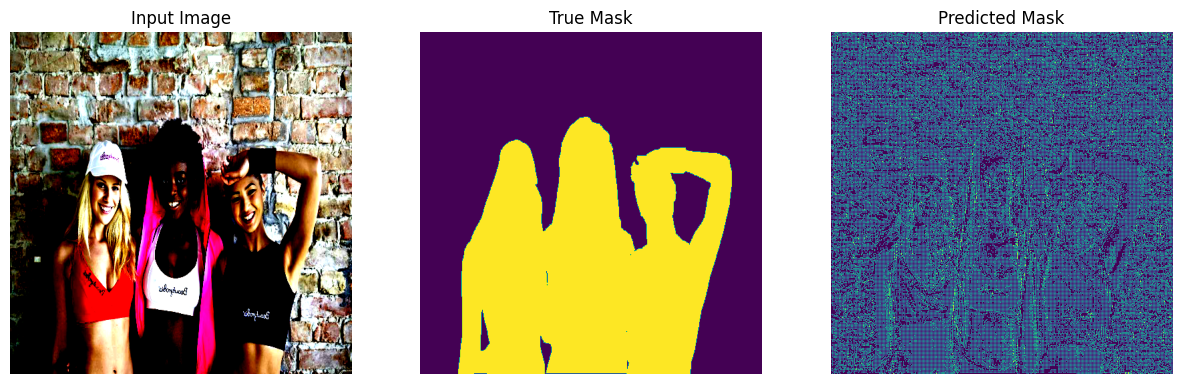

In [46]:
show_predictions(val_ds)

In [47]:
EPOCHS = 15
STEPS_PER_EPOCH = len(train_x)/BATCH_SIZE
VALIDATION_STEPS = len(val_x)/BATCH_SIZE

model_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/15
639/639 [==============================] - 170s 261ms/step - loss: 0.2042 - accuracy: 0.9195 - val_loss: 0.1744 - val_accuracy: 0.9314
Epoch 2/15
639/639 [==============================] - 161s 253ms/step - loss: 0.1766 - accuracy: 0.9298 - val_loss: 0.1450 - val_accuracy: 0.9424
Epoch 3/15
639/639 [==============================] - 151s 236ms/step - loss: 0.1639 - accuracy: 0.9346 - val_loss: 0.1377 - val_accuracy: 0.9452
Epoch 4/15
639/639 [==============================] - 153s 240ms/step - loss: 0.1539 - accuracy: 0.9389 - val_loss: 0.1305 - val_accuracy: 0.9475
Epoch 5/15
639/639 [==============================] - 158s 247ms/step - loss: 0.1489 - accuracy: 0.9405 - val_loss: 0.1318 - val_accuracy: 0.9470
Epoch 6/15
639/639 [==============================] - 156s 244ms/step - loss: 0.1436 - accuracy: 0.9431 - val_loss: 0.1281 - val_accuracy: 0.9491
Epoch 7/15
639/639 [==============================] - 149s 234ms/step - loss: 0.1389 - accuracy: 0.9446 - val_loss: 0.1266 -

1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


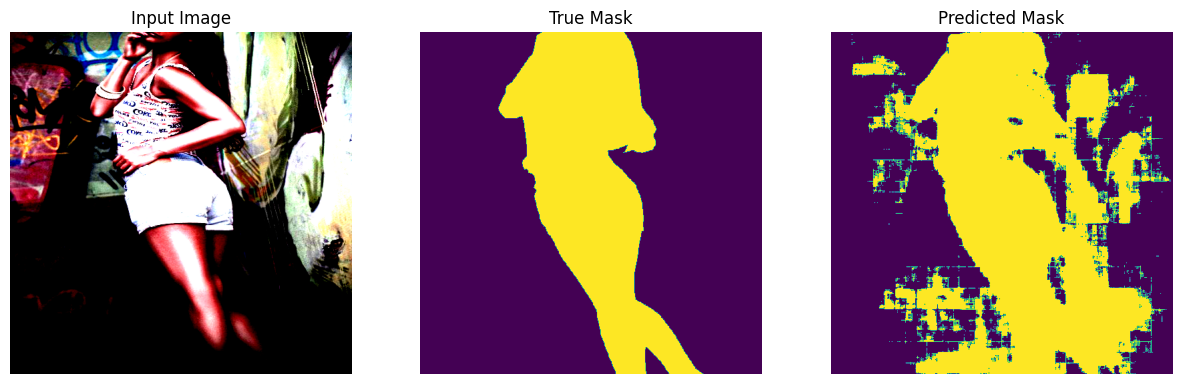

In [48]:
show_predictions(train_ds)

1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


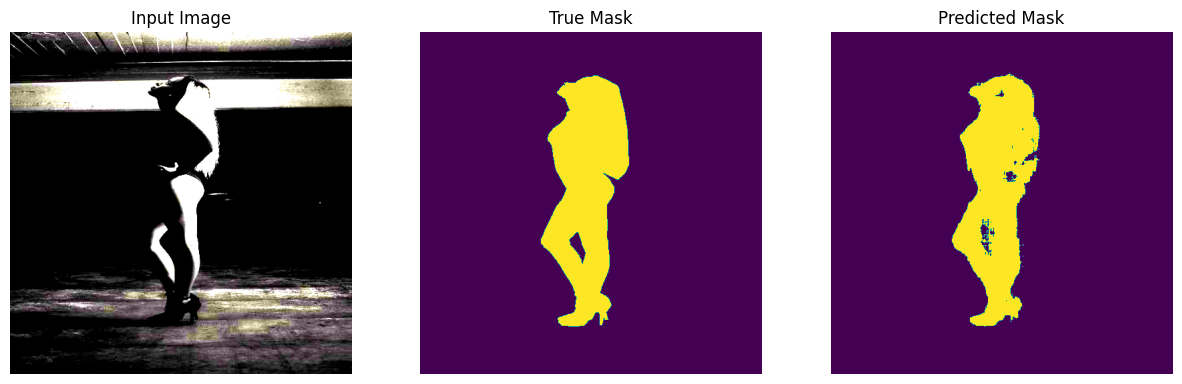

In [49]:
show_predictions(val_ds)

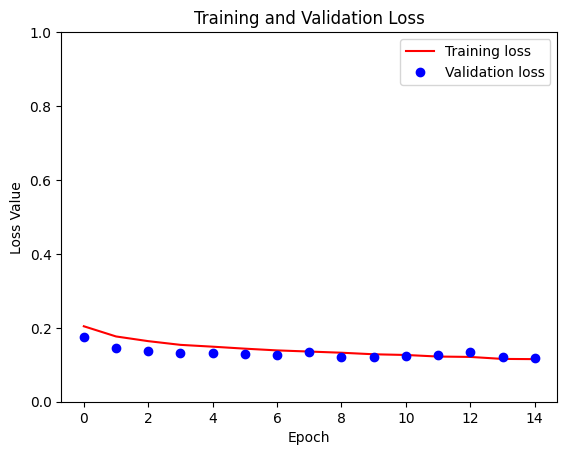

In [50]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [51]:
def delete_background(image, mask):
    mask = (tf.squeeze(mask, axis=-1))
    mask = tf.cast(mask, tf.dtypes.uint8).numpy()
    image = image.numpy()
    result = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    result[:, :, 3] = mask
    return result

In [52]:
from PIL import Image

In [53]:
def normalize_image(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

In [54]:
def to_png(image_arr):
    image = Image.fromarray((image_arr * 255).astype(np.uint8))
    image.save('image.png')

In [55]:
def parse_image_for_pred(image_path):
    image_content = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_content, channels=IMG_CHANNELS)
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, IMG_SIZE[:2]) 
    image = tf.expand_dims(image, axis = 0)
    return image

(1, 512, 512, 3)
1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


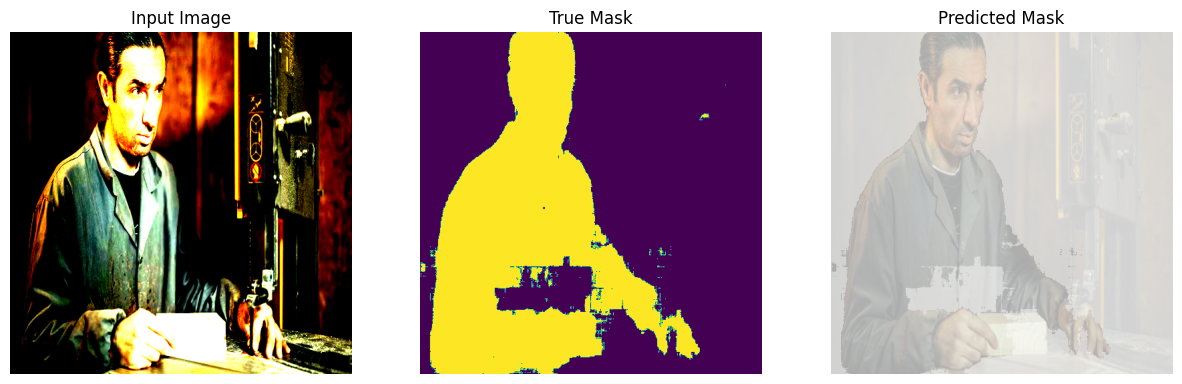

In [56]:
import numpy as np

image = parse_image_for_pred(val_x[5])
print(image.shape)

pred_mask = model.predict(image)
pred_mask = create_mask(pred_mask)
new_image = delete_background(image[0], pred_mask)
# new_image[new_image < 0] = 0
new_image = normalize_image(new_image)
to_png(new_image)


display([image[0], pred_mask, new_image])

##Save model

In [57]:
model.save('./model3.keras')

/home/karo/.local/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(
